# Seed-guided Topic model for UK Biobank EHR Data

This notebook samples from MixEHR-Seed model. MixEHR-Seed is a seed-guided, multi-modal topic model trained on Electronic Health Records (EHRs) data. To incorporate phenotype knowledge, MixEHR-Seed leverages known phenotype concepts and guides topic inference.

In this notebook, we provide a tutorial for running MixEHR-Seed on MIMIC dataset. The Key content includes

* **Process UKB EHR data**
* **Topic models for EHR**
* **Existing models and limitations**
* **Run MixEHR-Seed model**
 

[Li Lab Page](https://www.cs.mcgill.ca/~yueli/research.html) | [Paper](https://dl.acm.org/doi/10.1145/3534678.3542675) | [GitHub](https://github.com/li-lab-mcgill/MixEHR-Seed) | [Jupyter Notebook](https://github.com/li-lab-mcgill/MixEHR_Seed_Tutorial/blob/main/MixEHR_Seed_tutorial.ipynb)


# 1. Process UKB EHR Data

UKB is a large scale biomedical resource dataset.'Phenotype and genotype data available from 500k participants recruited since year 2006 with 95% being white European Descendant.

UKB dataset contains more than 4900 unique **fields** of phenotypic data

* Each field represents a type of data (ICD10, ICD9, OPCS, treatment)
* 41270-0.3
    * '41270' denotes a field, in this case, ICD-10 diagnostic codes
    * '0' denotes the occurrence of a patient's visit, in this case, the initial visit
    * '3' denotes the number of records, in this case, the third entry 
    * The code '41270-0.3' represents the the third ICD-10 code recorded for the patient during the inital visit.

<img src="images/UKB_fields.png" alt="UKB_fields" style="float: left;" width="400"/>

## 1. Process ICD-10 Code

In the Field #41270, UKB database contains patient records of ICD-10 codes.

* An example ICD-10 codes is S86
* 'S' is disease category. S represents injury, poisoning and certain other consequences of external causes
* '86' is specific disease type. S86 represents Injury of muscle and tendon at lower leg level


UKB employs a horizontal representation for its data, with each column representing a separate data entry:

* Up to 240 entries per patient
* Most individuals only have few entries, with 'Nan' filling the remaining slots
* This table is highly **sparse** as a marjorty of elements are Nan

| eid     | 41270-0.0 | 41270-0.1 | .... | 41270-0.240 |
|---------|-----------|-----------|------|-------------|
| 1000120 | S86    | K78       | .... | Nan   |
| 1000121 | I789    | Nan       | .... | Nan   |


We transform into the vertical representation. 

* The UKB database only has a single visit, each ICD-10 code only occur once

| eid     | ICD-10 |
|---------|--------|
| 1000120 | S86   |
| 1000120 | K78    |
| 1000120 | ....   |
| 1000121 | I789   |

We extracted 5.9M ICD-10 codes from the UKBB participants



### Link ICD-10 codes to PheCodes

To employ the MixEHR-Seed model, we will need to link the ICD-10 codes to corresponding PheCodes using the [PheWAS](https://github.com/li-lab-mcgill/MixEHR-Seed) system.

* A total of 9505 ICD-10 code mapped to at least one PheCode
* 5M ICD-10 codes can be mapped to PheCodes.

| eid     | ICD-10 | Phecode |
|---------|--------|---------|
| 1000120 | S86    |   1009  | 
| 1000120 | K78    |   Nan   | 
| 1000120 | ....   | ....    | 
| 1000121 | I789   |   448   | 





## 2. Process UKB Medication Code

In the Field #20003, UKB database contains patient records of treatment/medication.

| eid     | 20003-0.0   | 20003-0.1   | .... |
|---------|-------------|-------------|------|
| 1000120 | 1140861958  | 1141188146  | .... |
| 1000121 | 1140868226  | 1140876358  |  .... |

UKB database assigns different codes to varied dosages of the same medication.

* Hinder model to understand drug information.


| Codes   | Meaning             |
|-----------|-----------------------------|
| 1140861958 | Simvastatin |
| 1141188146 | Simvador 10mg tablet |
| 1140868226 | Aspirin          |
| 1140876358 | Unguentum cocois co |


### Map UKB medication code to ATC code 

The study referenced in [1] provides a mapping between UKB medication codes and ATC codes, which is detailed in the [supplementary material](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-09572-5/MediaObjects/41467_2019_9572_MOESM3_ESM.xlsx). This mapping aligns 6,745 UKB medication codes with 885 distinct ATC codes.

| eid     | UKB code  | ATC code |
|---------|------------|----------|
| 1000120 | 1140861958 | C10AA01  |
| 1000120 | 1141188146 | C10AA01  |
| 1000121 | 1140868226 | A01AD05  |
| 1000121 | 1140876358 | Nan  |


Since multiple medication codes can be mapped to a same ATC code, we compute teh We combine the frequency of ATC codes for each indivudial. 

* Rows with an ATC code of 'NaN' were excluded from this aggregation.


| eid     | UKBB code  | ATC code | Freq |
|---------|------------|----------|------|
| 1000120 | 1140861958 | C10AA01  | 2    |
| 1000121 | 1140868226 | A01AD05  | 1    |
| ...     | ...        | ...      | ...  |

[1] Wu, Y., Byrne, E.M., Zheng, Z. et al. Genome-wide association study of medication-use and associated disease in the UK Biobank. Nat Commun 10, 1891 (2019). https://doi.org/10.1038/s41467-019-09572-5

## 3. Process OPCS code

In the Field #41272, UKB database contains patient records of OPCS-4 procedure codes

It encodes operations, procedures, and interventions performed during in-patient stays, day case surgery, and some outpatient treatments in NHS hospitals. OPCS-4 code will have maximum 1 decimal place. 

* 'A' is the Chapter. A represents Nervous system
* '01' the Types of procedure. 01 is Major excision of tissue of brain
* '.1' is the Exact procedure. .1  is Hemispherectomy

| eid     | 41272-0.0   | 41272-0.1   | .... |
|---------|-------------|-------------|------|
| 1000120 | A042  | E018 | .... |
| 1000121 | B121  | NaN         |  .... |

We identify 8403 OPCS-4 procedure codes. Similarly, we transform from horizontal to vertical format.

| eid     | OPCS-4 Code | 
|---------|------------|
| 1000120 | A042 |
| 1000120 | E018 |
| 1000121 | B121 | 


### Summary of EHR Pre-processing

Among 502K participants, 474K individuals with at least one available codes.

To remove rare codes, we filter out EHR codes by:
* exclue all EHR codes with fewer than 10 occurrences
* remove Phecode topics with less than 1000 cases

The final EHR data contains:
* 6954 distinct ICD10 codes corresponding to 1502 Phecodes
* 885 distinct ATC codes
* 2560 distinct OPCS procedure codes

# 2. Topic Modeling for EHR

## What are EHRs?

EHRs collect patients' **heterogenous** medical histories including

* Diagnosis (ICD code, International classification of Diseases code)
* Medication
* Lab test
* Doctor note


Key objectives of EHR modeling:

* **Prediction**: disease development, drug recommendation, mortality rate.

* **Disease Interpretability**: understanding disease representations, comorbidity, disease progression.

<img src="images/EHR_data.png" alt="EHR_data" style="float: left;" width="700"/>



## What is Topic Modeling?

Topic models are probabilistic models that learns **topics** within a collection of documents.

* Each document contains multiple words
* **Each topic is a distribution of words that frequently occur together**
* Each document can contain multiple topic in different probabilties

Outputs of topic models:

*   Topic representation: a topic × vocabulary matrix, each topic is a distribution over words 
*   Document-topic proportion: a document × topic matrix, each document is a distribution of topics


<img src="images/topic_model.png" alt="topic_model" style="float: left;" width="800"/>


## Apply Topic Models to EHR Data

What is document, word, topics in EHR data?

* Each patient’s medical history is a 'document'
* Diagnoses (ICD diagnostic codes) are 'words' within a document
* Disease is considered as a 'topic'


### Outputs of topic models

* **Disease topic representation**: each disease topic is a distribution of diagnoses 
    - Cardiovascular disease topic has frequent heart failure diagnoses
* **Patient-topic proportion**: the distribution of disease topics for each patient, the probability of a disease topic can be viewed as disease risk 

<img src="images/EHR_modeling.png" alt="EHR_modeling" style="float: left;" width="800"/>



## Use MIMIC-III Toy Data

The MIMIC-III dataset is a publicly-available clinical data related to a diverse patient population managed in critical care units. 

We selected a toy data of **ICD diagnostic codes** in the folder.


In [4]:
import pandas as pd
data = pd.read_csv('./data/icd_toy_data_lda.csv')
data.head(3)

,SUBJECT_ID,ICD9,FREQ
0,53192,49320,1
1,27098,49390,1
2,4647,49390,1


# 3. Existing Models and Limitations

## Latent Dirichlet Allocation (LDA)

LDA is a basic and widely-used topic model. We utilize the 'sklearn' library for its implementation.


In [14]:
from sklearn.decomposition import LatentDirichletAllocation

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Group the ICD9 codes and convert them into a document for each patient
data['ICD9'] = data['ICD9'].astype(str)
documents = data.groupby('SUBJECT_ID')['ICD9'].apply(lambda icd_codes: ' '.join(icd_codes)).reset_index(name='document')

# Vectorize the ICD9 code documents
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents['document'])

print("Transform into an input of document-vocabulary matrix:", X.shape) 

Transform into an input of document-vocabulary matrix: (3427, 139)


In [31]:
# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(X)

LatentDirichletAllocation(random_state=0)

In [38]:
import numpy as np
# Topic distribution for each document
topic_distribution = lda.transform(X)

# Topic proportions (word distributions for each topic)
topic_proportions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Print the shape of the topic distribution
print("Shape of topic representation is (topic x vocabulary):", topic_distribution.transpose().shape)

# Print the shape of the topic proportions
print("Shape of topic proportions is (document x topic):", topic_proportions.transpose().shape)


Shape of topic distribution is (topic x vocabulary): (10, 3427)
Shape of topic proportions is (document x topic): (139, 10)


## Manually Interpret Disease Topic Representation

Since the learned topics are the distributions over ICD codes, we interpret each disease topic by showing the top 3 ICD codes.

In [36]:
# Load the ICD descriptions dataset
icd_descriptions = pd.read_csv('./data/D_ICD_DIAGNOSES.csv')

# Create a dictionary mapping ICD codes to their long descriptions
icd_to_description = pd.Series(icd_descriptions['LONG_TITLE'].values, index=icd_descriptions['ICD9_CODE']).to_dict()

# Assuming 'lda' is your trained LDA model and 'vectorizer' is the CountVectorizer
feature_names = vectorizer.get_feature_names_out()
word_distributions = lda.components_

# Map the top words to their descriptions for each topic
top_descriptions_per_topic = []
for topic_idx, word_distribution in enumerate(word_distributions):
    top_icd_indices = word_distribution.argsort()[-3:][::-1]  # Get indices of the top words
    top_icd_codes = [feature_names[i] for i in top_icd_indices]
    top_icd_descriptions = [icd_to_description.get(icd_code, 'Unknown Diagnosis') for icd_code in top_icd_codes]
    top_descriptions_per_topic.append(top_icd_descriptions)

# Print out the top descriptions for each topic
for idx, descriptions in enumerate(top_descriptions_per_topic):
    print(f"Topic {idx+1}:")
    for description in descriptions:
        print(description)
    print("\n")


Topic 1:
Human immunodeficiency virus [HIV] disease
Schizoaffective disorder, unspecified
Obstructive chronic bronchitis with (acute) exacerbation


Topic 2:
Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified
Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage V or end stage renal disease
Chronic diastolic heart failure


Topic 3:
Chronic airway obstruction, not elsewhere classified
Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled
Subendocardial infarction, initial episode of care


Topic 4:
Unspecified essential hypertension
Unknown Diagnosis
Paranoid type schizophrenia, unspecified


Topic 5:
Epilepsy, unspecified, without mention of intractable epilepsy
Grand mal status
Diabetes with renal manifestations, type II or unspecified type, not stated as uncontrolled


Topic 6:
Coronary atherosclerosis of native coronary artery
Chroni

### Topic 2: Chonic kidney disease

* Assign highest probabilites to Hypertensive Chronic Kidney Disease and Chronic Diastolic Heart Failure
* In patients with chonic kidney disease, diastolic dysfunction are more frequent


## Interpret Document-topic Proporition

For each patient document, the LDA learns a distribution over topics (disease risk scores).

We observe the highest probability for topic 6, indicating the most severe disease risk.


In [51]:
# Assuming 'X' is your document-term matrix and 'lda' is your fitted LDA model
import random
random_patient_index = random.randint(0, 1000)
patient_topic_distribution = lda.transform(X[random_patient_index:random_patient_index+1])

# Now, patient_topic_distribution contains the topic distribution for the selected patient
print(f"Topic distribution for patient at index {patient_index}:")
print(patient_topic_distribution)

Topic distribution for patient at index 25:
[[0.05 0.05 0.05 0.05 0.05 0.55 0.05 0.05 0.05 0.05]]


## Limitations of Classic Topic Models


### Limitation 1. Require human interpretation 

* Pre-define the number of topics
* Manually interpret learned topics to determine their meaning
* Require clinical knowledge to interpret


### Limitation 2. It only learns single modality (ICD codes) 

* Medication, lab test, doctor note also help understand the patient's condition




## Solution 1: Phenotype-guided Topic Model

The [PheWAS](https://github.com/li-lab-mcgill/MixEHR-Seed) is expert-defined mapping system for disease categorization.

Each disease is defined by a phenotype code (PheCode), which corresponds to a set of related ICD codes.

| Diseases | PheCodes | ICD-9 Codes |
|----------|----------|-------------|
| Asthma  | 495.2   | 493.x, ... |
| COPD    | 496.2   | 491.x, ... |
| ...     | ...     | ...         | 


### Incorporate PheWAS into Topic Modeling (MixEHR-Seed)

View each PheCode as a  pre-established disease topic, which is linked to **related ICD codes** .

Removes the requirement to pre-determine the number of topics.
Foregoes the necessity of manual topic interpretation.

* Do not require pre-defined topic number

* Pre-establish topic meaning

* Incorporate expert-defined PheWAS categorizations directly into model

When encounter ICD codes (493.xx), it assigns higher weight for target phenotype topic (495.2 asthma).

## Solution 2. Process Heterogeneous MIMIC Data

The EHRs in MIMIC dataset include six heterogenous modelities:

* ICD
* Prescription
* Diagnosis-related group (DRG)
* Current Procedural Terminology (CPT)
* Lab test
* Doctor notes

where only ICD modality is guided by PheWAS. 


In [ ]:
icd_data = pd.read_csv('/content/MIMIC_toy_data/icd_toy_data.csv')
icd_data.head(3)

,SUBJECT_ID,HADM_ID,ICD9,PheCode,FREQ
0,53192,123631,49320,495.10,1
1,27098,152184,49390,495.00,1
2,4647,141820,49390,495.00,1
3,29274,190222,49322,495.11,1
4,1200,137450,49320,495.10,1


In [16]:
pres_data = pd.read_csv('/content/MIMIC_toy_data/pres_toy_data.csv')
pres_data.head(3)

,SUBJECT_ID,COMPOUND_ID,FREQ
0,7981,Neutra-Phos-Neutra-Phos-016905-17314931102,3
1,12080,Heparin-Heparin Sodium-006549-00641040025,1
2,69426,Gabapentin-Gabapentin-021413-68084007965,2


# 4. Run MixEHR-Seed Model

The MixEHR-Seed improves over classic two model in two aspects:

* Improvement 1: use the PheWAS-guidance from expert-defined phenotypes to learn meaningful disease topics.
* Improvement 2: includes multiple data types to learns heterogeneous disease topics


### Outputs:

*   Disease topic representation: For each data type, the disease topic is a distrubtion of words (ICD, medications,...).
*   Patient-topic proportion: Each patient is a distribution of disease topics, indicating disease risk scores. 

## Step 1: Process Dataset and Extract Seeds


### Prepare data

The EHR data is located in the `./data` directory. 

* It requires **mandatory ICD codes**.
Headers:, ICD9, PheCode, FREQ


| SUBJECT_ID | ICD9  | PheCode | Freq |
|------------|-------|---------|------|
| 53192      | 49320 | 495.10  | 1    |
| 27098      | 49390 | 494.00  | 2    |
| ...        | ...   | ...     | ...  |

* It can include **any other types** as complementary information, such as medication.


| SUBJECT_ID | ***type_name***   | Freq |
|------------|-------|------|
| 7981      | Neutra-Phos | 1    |
| 12080      | Heparin | 2    |
| ...        | ...   | ...  |


### Process data

This procedure generates a ***Corpus*** data object that can be executed by the MixEHR-Seed model. To generate and save the processed corpus in the `./store` directory, execute the `./corpus.py` with the following command:

```
run(parser.parse_args(['process', '-n', '150', './data/', './store/']))
```

In [52]:
%run ./corpus.py process -n 150 ./data/ ./store/

./data/
./store/
                           path  word_column
index                                       
icd     ./data/icd_toy_data.csv         ICD9
pres   ./data/pres_toy_data.csv  COMPOUND_ID
cpt     ./data/cpt_toy_data.csv    ICD9_CODE
drg     ./data/drg_toy_data.csv  COMPOUND_ID
lab     ./data/lab_toy_data.csv        LABEL
note   ./data/note_toy_data.csv         TERM
['icd', 'pres', 'cpt', 'drg', 'lab', 'note']
{'icd': './data/icd_toy_data.csv', 'pres': './data/pres_toy_data.csv', 'cpt': './data/cpt_toy_data.csv', 'drg': './data/drg_toy_data.csv', 'lab': './data/lab_toy_data.csv', 'note': './data/note_toy_data.csv'}
{'icd': 'ICD9', 'pres': 'COMPOUND_ID', 'cpt': 'ICD9_CODE', 'drg': 'COMPOUND_ID', 'lab': 'LABEL', 'note': 'TERM'}
      SUBJECT_ID  HADM_ID   ICD9  PheCode  FREQ
0          53192   123631  49320   495.10     1
1          27098   152184  49390   495.00     1
2           4647   141820  49390   495.00     1
3          29274   190222  49322   495.11     1
4           1200

100.0000  - document(19533), word(123): 100%|█████████████████████████████████████| 3600/3600 [00:04<00:00, 753.60it/s]


1 pres


100.0000  - document(54494), word(698): 100%|███████████████████████████████████| 13500/13500 [00:17<00:00, 791.69it/s]


2 cpt


100.0000  - document(2374), word(238): 100%|██████████████████████████████████████| 2700/2700 [00:03<00:00, 746.48it/s]


3 drg


100.0000  - document(1407), word(42): 100%|███████████████████████████████████████| 1800/1800 [00:02<00:00, 808.78it/s]


4 lab


100.0000  - document(32037), word(179): 100%|███████████████████████████████████| 27000/27000 [00:33<00:00, 817.36it/s]


5 note


97.6615  - document(23366), word(1053):  98%|████████████████████████████████▏| 131842/135000 [02:52<00:03, 791.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0000  - document(13627), word(8658): 100%|████████████████████████████████| 135000/135000 [02:56<00:00, 766.23it/s]


INFO:__main__:Creating corpus...
INFO:__main__:
        ========= DataSet Information =========
        Documents: 3427
        Word Tokens for each modality: [139, 1914, 406, 716, 376, 28248]
        
INFO:__main__:Saving: 
	./store/corpus.pkl
INFO:__main__:Data stored in ./store/


# Step 2: Run An Informative Initialization (Optional)

To ensure a more an more informative starting point, we compute disease topic prior for patient topic proportion, guided by established phenotypes.

It's essential to execute the following scripts, which aggregates phenotype data, assigns appropriate priors, and computing token counts. You need to run the following three files:

```
  python ./guide_prior/get_doc_phecode.py
```

```
  python ./guide_prior/get_prior_GMM.py
```

```
  python ./guide_prior/get_token_counts.py
```
  
Executing the `./guide/prior/init_tokens.py` script automatically processes these files and stores the initilized files within the `./guide_prior/init_tokens/` directory.

<img src="images/guide_patient_topic_mixture.png" alt="guide_patient_topic_mixture" style="float: left;" width="800"/>


In [78]:
%cd guide_prior
%run ./init_tokens.py
%cd ..

C:\Users\ziyan\PycharmProjects\tokyo_talk\guide_prior
Successfully ran ../guide_prior/get_doc_phecode.py
obtain D x K document-PheCode count matrix
Document id: (53192), Words [1, 5, 1, 0, 13, 57], Count [1, 12, 1, 0, 24, 224] tensor(1., device='cuda:0')
Document id: (27098), Words [1, 5, 0, 1, 11, 31], Count [1, 7, 0, 2, 16, 36] tensor(1., device='cuda:0')
Document id: (4647), Words [1, 0, 0, 0, 9, 23], Count [1, 0, 0, 0, 29, 29] tensor(1., device='cuda:0')
Document id: (29274), Words [1, 3, 0, 0, 13, 54], Count [1, 13, 0, 0, 290, 72] tensor(1., device='cuda:0')
Document id: (1200), Words [1, 0, 0, 0, 2, 4], Count [1, 0, 0, 0, 2, 7] tensor(1., device='cuda:0')
Document id: (91426), Words [3, 13, 5, 1, 17, 94], Count [3, 29, 8, 1, 205, 147] tensor(3., device='cuda:0')
Document id: (12021), Words [1, 4, 0, 0, 11, 41], Count [1, 5, 0, 0, 18, 65] tensor(1., device='cuda:0')
Document id: (65190), Words [1, 1, 0, 0, 4, 22], Count [1, 1, 0, 0, 34, 29] tensor(1., device='cuda:0')
Document id:

Successfully ran ../guide_prior/get_prior_GMM.py
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47

Successfully ran ../guide_prior/get_token_counts.py
[139, 1914, 406, 716, 376, 28248]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209


## Step 3: Run MixEHR-Seed Model

To apply seed-guided topic modeling to the processed corpus, we execute the ./main.py file.


```
run(parser.parse_args(['./store/', './parameters/']))
```   

In [80]:
%run ./main.py

cuda
V and K are torch.Size([139, 48])
trained modalities include ['icd', 'pres', 'cpt', 'drg', 'lab', 'note']
Obtain initialized tokens
INFO:MixEHR-Seed training processing:
    #     ======= Parameters =======
    #     mode: 		training
    #     file:		./store/
    #     output:		./parameters/
    #     max iterations:	5
    #     batch size:	5000
    #     save every:		1
    #     ==========================
    # 
Training for epoch 0
Running for %d minibatch 0
elbo:  -12738.025730345324
Training for epoch 1
Running for %d minibatch 0
elbo:  -14172.753221206722
Training for epoch 2
Running for %d minibatch 0
elbo:  -15130.164965646949
Training for epoch 3
Running for %d minibatch 0
elbo:  -15824.541939890805
Training for epoch 4
Running for %d minibatch 0
elbo:  -16350.736742026505
epoch : [-12738.025730345324, -14172.753221206722, -15130.164965646949, -15824.541939890805, -16350.736742026505]


## Step 4: Evalution

The outputs are saved at ./parameters/, we can evaluate the topic interpretability and phenotype prediction.


C:\Users\ziyan\PycharmProjects\tokyo_talk\plot


C:\Users\ziyan\PycharmProjects\tokyo_talk\plot\utils.py:315: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


C:\Users\ziyan\PycharmProjects\tokyo_talk


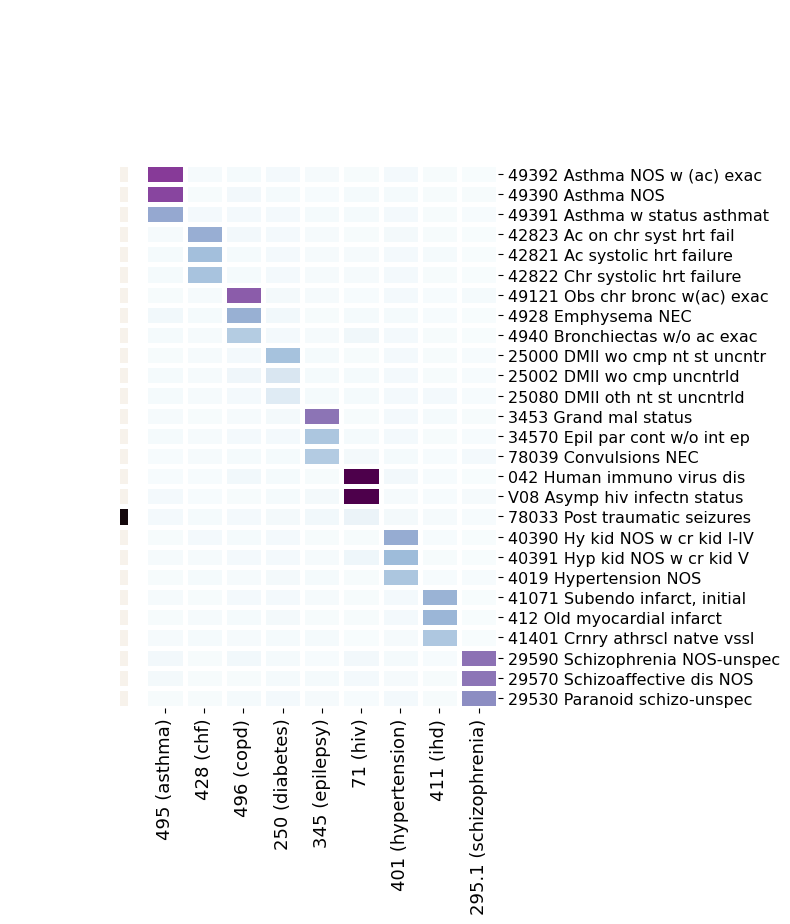

In [1]:
%cd ./plot
%run ./Heatmap_ICD.py
%cd ..

## Interpret the ICD Heatmap 

For each of the nine chosen phenotypes, we display the three highest-scoring ICD codes associated with each topic. A darker shade  indicates a higher probability.

The sidebar indicates if a top ICD code is identified as a seed (highlighted in yellow) for its respective topic.

* Most of ICD codes are seed codes for their topics
* Most of ICD codes are related to disease topics. For example, top 3 ICD codes are asthma-related codes for topic 495 (asthma)



C:\Users\ziyan\PycharmProjects\tokyo_talk\plot
C:\Users\ziyan\PycharmProjects\tokyo_talk


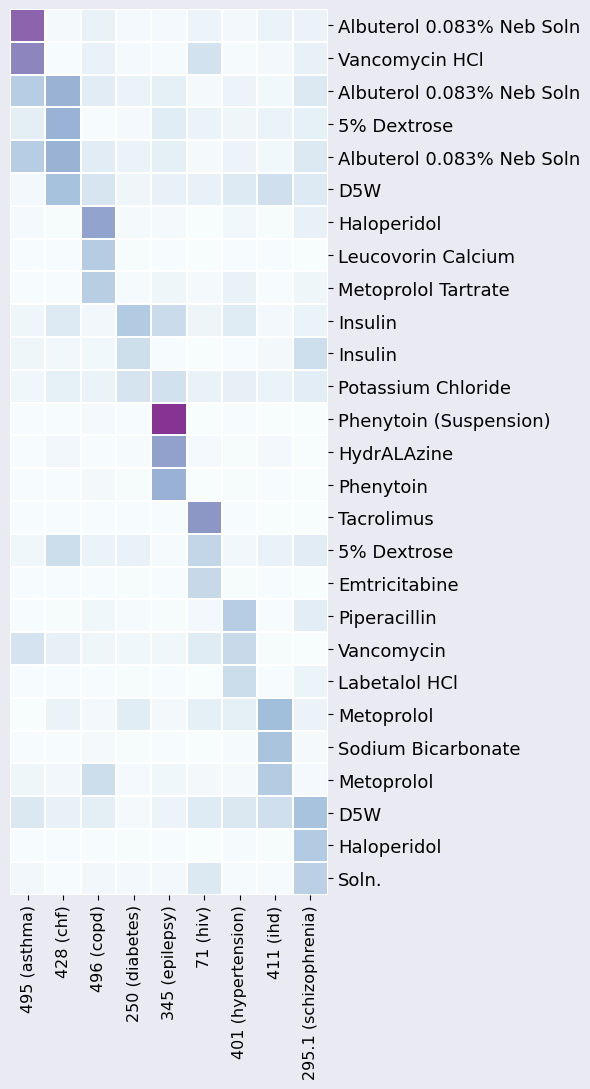

In [2]:
%cd ./plot
%run ./Heatmap_Prescription.py
%cd ..


## Interpret the Prescription Heatmap

For each of the nine chosen phenotypes, we display the three highest-scoring **drugs** associated with each topic. A darker shade indicates a higher probability.

Although prescription modality is not guided, it is still interpretable

* Top drug diabetes are frequently occured in Topic 250 (Diabetes)
* Top drug metoprolol are frequently observed in Ischemic heart disease (IHD)metoprolol lowers blood pressure and heart rate 

## Automatic Phenotyping by MixEHR-Seed

For patient-topic proportion, each element represents the disease risk for a patient. We can predict multiple diseases in the same time.

<img src="images/topic_mixture.png" alt="topic_mixture" style="float: left;" width="400"/>


We consider adding the following modalities:

1. ICD-10 diagnostic codes
2. Anatomical Therapeutic Chemical (ATC) codes
3. OPCS Classification of Interventions and Procedures (OPCS-4) codes
4. Genotype data